In [3]:
import numpy as np
import pandas as pd
pd.plotting.register_matplotlib_converters()

from fbprophet import Prophet
from sklearn.metrics import mean_absolute_error as mae

import matplotlib.pyplot as plt
%matplotlib inline


In [4]:
path = 'https://raw.githubusercontent.com/dataworkshop/5dwchallenge_2019/master/challenge5/input/visits.csv'

df = pd.read_csv(path, parse_dates=['published'], index_col='published')
df.head()

,post_id
published,
2008-01-01 18:19:00,18284
2008-01-01 18:30:00,18285
2008-01-01 18:34:00,18286
2008-01-02 01:32:00,18291
2008-01-02 14:34:00,18294


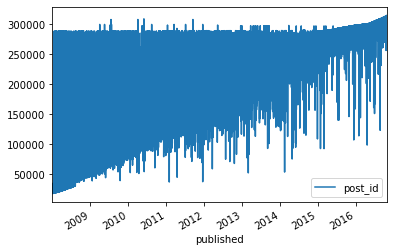

In [5]:
df.plot();

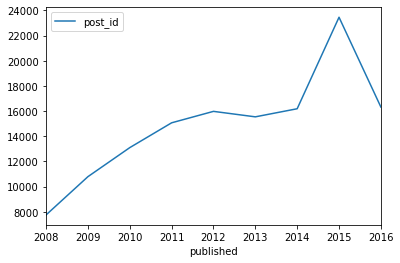

In [6]:
df.resample('1Y').count().plot();
#df.resample('1m').count() -regularnosc - rok  tj. ile w roku  artykulow publikowano

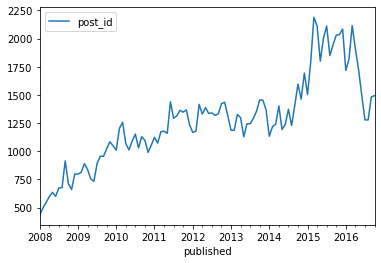

In [7]:
df.resample('1M').count().plot();
#ile napisano per miesiac

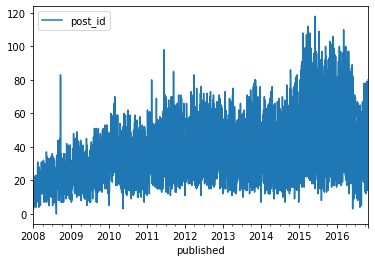

In [8]:
df.resample('1D').count().plot();
#ile napisano per dzien

# Prognozujemy per dzien

In [9]:
#Tworzymy nowy set
df_day = df.resample('1D').count().reset_index()
#zmieniamy nazwy z published i post_id na 
df_day.columns = ['ds', 'y']

df_day

,ds,y
0,2008-01-01,3
1,2008-01-02,3
2,2008-01-03,4
3,2008-01-04,14
4,2008-01-05,4
...,...,...
3222,2016-10-27,58
3223,2016-10-28,53
3224,2016-10-29,14
3225,2016-10-30,27


# Walidacja

In [10]:
num_points_to_pred = 30

#-num_points_to_pred -oznacza odlicz 30 punktow od konca i masz tam skonczyc, czyli bierze od samego poczatku a konczy 30 przed koncem
# .........train.................|...test... (test to te ostatnie 30 od konca)
train = df_day[:-num_points_to_pred]
test = df_day[-num_points_to_pred:]
#test - mozemy  na koncu przed  zostawic : albo wyliczyc liczbe wszystkich wartosci -1
#test - startujemy na 30 - od konca - to nasz poczatek dla testu

# Budujemy modele

In [11]:
m = Prophet()
m.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\user\Anaconda3\envs\challenge5\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [12]:
future = m.make_future_dataframe(periods=num_points_to_pred, freq='D', include_history=True)
future

,ds
0,2008-01-01
1,2008-01-02
2,2008-01-03
3,2008-01-04
4,2008-01-05
...,...
3222,2016-10-27
3223,2016-10-28
3224,2016-10-29
3225,2016-10-30


# Prognozowanie

In [13]:
forecast = m.predict(future)

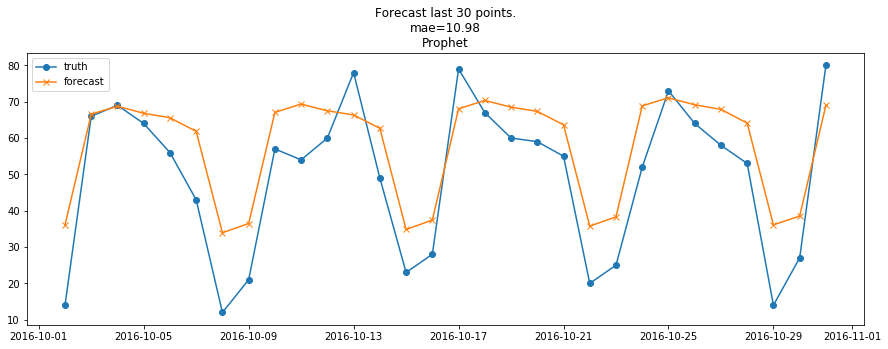

In [14]:
def plot_forecast(test, forecast):
    forecast = forecast[-num_points_to_pred:]
    score = np.round(mae(test.y, forecast.yhat), 2)
    
    plt.figure(figsize=(15, 5))
    plt.title('Forecast last {} points.\nmae={}\nProphet'.format(num_points_to_pred, score))
    plt.plot(test.ds, test.y, 'o-', label='truth')
    plt.plot(test.ds, forecast.yhat, 'x-', label='forecast')
    plt.legend()
    
plot_forecast(test, forecast)

In [ ]:
#ulepszamy forecast dla wiekszych wartosci niz 30 
#logarytmizacja danych


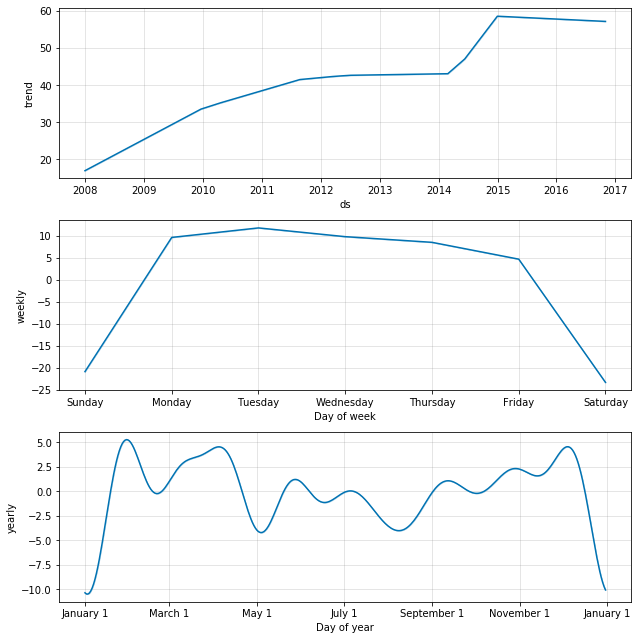

In [15]:
m.plot_components(forecast);
#pokazuje jak wyglagadaja trendy
#prophet pokazuje czy sa sezony- tutaj czy sa  szeony tygodniowe, czy roczne
#prophet jest zbudowany w facebooku i akurat te dwa sezony sa najbardziej dla niego istotne

In [16]:
len(train), len(test)

(3197, 30)

In [17]:
from fbprophet.diagnostics import cross_validation

#horizon='30 days' - oznacza prognozowanie o 30 dni do przodu
df_cv = cross_validation(m, initial='2500 days', period='10 days', horizon='30 days')

INFO:fbprophet:Making 67 forecasts with cutoffs between 2014-11-11 00:00:00 and 2016-09-01 00:00:00
C:\Users\user\Anaconda3\envs\challenge5\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [18]:
df_cv.shape

(2010, 6)

In [19]:
#zaawansowana opcja
df_cv.groupby('cutoff').count()

,ds,yhat,yhat_lower,yhat_upper,y
cutoff,,,,,
2014-11-11,30,30,30,30,30
2014-11-21,30,30,30,30,30
2014-12-01,30,30,30,30,30
2014-12-11,30,30,30,30,30
2014-12-21,30,30,30,30,30
...,...,...,...,...,...
2016-07-23,30,30,30,30,30
2016-08-02,30,30,30,30,30
2016-08-12,30,30,30,30,30


In [22]:
performance_metrics(df_cv)

,horizon,mse,rmse,mae,mape,coverage
0,3 days,371.150304,19.265262,16.287132,0.565282,0.427861
1,4 days,335.708456,18.322349,15.714201,0.436009,0.427861
2,5 days,346.736224,18.620855,15.821907,0.476809,0.457711
3,6 days,349.748861,18.701574,15.630649,0.459993,0.492537
4,7 days,377.628811,19.432674,16.180060,0.468095,0.467662
5,8 days,369.660024,19.226545,15.836047,0.437173,0.477612
6,9 days,360.744145,18.993266,15.715614,0.436389,0.462687
7,10 days,404.194842,20.104598,16.477319,0.472467,0.457711
8,11 days,417.506722,20.432981,16.715496,0.585568,0.447761
9,12 days,424.200999,20.596140,17.209722,0.588146,0.417910


NameError: name 'plot_cross_validation_metric' is not defined